In [1]:
import sys,os
os.chdir('../')
sys.path.append('./src/data')
sys.path.append('./src/events')
sys.path.append('./src/probability')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from functions import nufit_params_nsi, nufit_params_nsi_IO
from PINGU.event_processing import return_precomputed_nsi, to_hist
from PINGU.event_processing import get_deltachi as deltachi_PINGU
from DC.event_processing import get_param_list, list_of_params_nsi, marginalize, marginalize_one
from DC.event_processing import get_deltachi as deltachi_DC
from IC.event_processing import get_deltachi as deltachi_IC
from IC.event_processing import normalize_events
from scipy.stats import chi2
import pickle
from scipy.interpolate import splrep, splev, sproot
from src.plotter import save, savethesis
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
np.set_printoptions(linewidth=200)
np.set_printoptions(precision=4)
df_I = pd.DataFrame()
df_D = pd.DataFrame()
df_ID = pd.DataFrame()

df_P = pd.DataFrame()
df_PD = pd.DataFrame()
df_PID = pd.DataFrame()

In [2]:
ndim = 3
livetime = 3*365*24*3600 #Effective livetime
ordering = 'NO'
IO = False if ordering == 'NO' else True
worst_cases={}
normal_cases={}
best_cases={}
chisq = {}
nsi_list = ['ett','emt','eem','eet']
experiment_list_full = ['P','D','PD','I', 'ID', 'PID']

ett = 7e-2
emt = 3e-2
eem = 3e-1
eet = 3e-1

sigma_a = 0.25
sigma_b = 0.04
f_PINGU = [0, 0.03, 0.05]
f_DC = 1
f_IC = [0.05, 0.1, 0.15]
N_IC = 13
N_nsi = 9
N_nsi_fine = 49
e_ranges=[np.linspace(-ett,ett,N_nsi),
            np.linspace(-emt,emt,N_nsi),
            np.linspace(-eem,eem,N_nsi),
            np.linspace(-eet,eet,N_nsi)]
fine_e_ranges=[np.linspace(-ett,ett,N_nsi_fine),
                np.linspace(-emt,emt,N_nsi_fine),
                np.linspace(-eem,eem,N_nsi_fine),
                np.linspace(-eet,eet,N_nsi_fine)]


In [3]:
for i,nsi_param in enumerate(nsi_list):
    ettN,emtN,eemN,eetN = 0,0,0,0
    experiment_list = ['P','D','PD']
    if nsi_param == 'ett':
        ettN = 1
    elif nsi_param == 'emt':
        emtN = 1
    elif nsi_param == 'eem':
        eemN = 1
    elif nsi_param == 'eet':
        eetN = 1
    dm31_range, th23_range,ett_range, emt_range, eem_range, eet_range = get_param_list(dm31N=5, 
                                                                                    th23N=5, 
                                                                            ett_tuple=(-ett,ett,N_nsi*ettN+1), 
                                                                            emt_tuple=(-emt,emt,N_nsi*emtN+1), 
                                                                            eem_tuple=(-eem,eem,N_nsi*eemN+1), 
                                                                            eet_tuple=(-eet,eet,N_nsi*eetN+1), 
                                                                            IO=IO)
    param_dict = nufit_params_nsi_IO if ordering == 'IO' else nufit_params_nsi     
    param_list = list_of_params_nsi(param_dict, dm31_range, th23_range,ett_range, emt_range, eem_range,eet_range)

    H1_DC = pickle.load(open(f'./pre_computed/H1_{ordering}_DC_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p','rb'))*livetime

    H1_PINGU = pickle.load(open(f'./pre_computed/H1_{ordering}_PINGU_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p','rb'))*livetime

    H0_PINGU = pickle.load(open(f'./pre_computed/H0_{ordering}_PINGU.p','rb'))*livetime


    if len(emt_range) > 1:
        H1_events_list = pickle.load(open(f'./pre_computed/H1_NO_IC_N{N_IC}_{len(dm31_range)}x{len(th23_range)}x{len(emt_range)}.p','rb'))
        H0_events = pickle.load(open(f'./pre_computed/H0_IC_N{N_IC}_nsi.p','rb'))
        H0_normalized, H1_list_normalized = normalize_events(H0_events,H1_events_list,np.arange(0,20))
        H1_IC = np.array(H1_list_normalized)
    

    for case in range(3):
        if case == 0:
            case_dict = best_cases
        elif case == 1:
            case_dict = normal_cases
        elif case == 2:
            case_dict = worst_cases
        D_chisq, D_best_fit_index  = deltachi_DC(H1_DC,0,[sigma_a,sigma_b], f_DC, x0=[1,0])
        P_chisq,  P_best_fit_index = deltachi_PINGU(H1_PINGU,H0_PINGU,0,[sigma_a,sigma_b],f_PINGU[case],x0=[1,0])
        PD_chisq =  P_chisq  + D_chisq - P_chisq.min() - D_chisq.min()
        PD_best_fit_index = np.argmin(PD_chisq)
        chisq['D'] = D_chisq
        chisq['P'] = P_chisq
        chisq['PD'] = PD_chisq
        case_dict[f'D_{nsi_param}_index'] = D_best_fit_index
        case_dict[f'P_{nsi_param}_index'] = P_best_fit_index
        case_dict[f'PD_{nsi_param}_index'] = PD_best_fit_index

        if len(emt_range) > 1:
            experiment_list += ['I', 'ID', 'PID']
            I_chisq, I_best_fit_index = deltachi_IC(H1_IC,0,[sigma_a,sigma_b],f_IC[case],x0=[1,0])

            ID_chisq =  D_chisq + I_chisq
            ID_best_fit_index = np.argmin(ID_chisq)
            PID_chisq =  PD_chisq + I_chisq
            PID_best_fit_index = np.argmin(PID_chisq)
            I_chisq = I_chisq
            chisq['I'] = I_chisq
            chisq['ID'] = ID_chisq
            chisq['PID'] = PID_chisq
            case_dict[f'I_{nsi_param}_index'] = I_best_fit_index
            case_dict[f'ID_{nsi_param}_index'] = ID_best_fit_index
            case_dict[f'PID_{nsi_param}_index'] = PID_best_fit_index
  
        for experiment in experiment_list:
            marginalized_chisq = marginalize(chisq[experiment], dm31_range, th23_range, ett_range, emt_range, eem_range, eet_range)[0]
            interpolated_chisq= splev(fine_e_ranges[i],splrep(e_ranges[i], marginalized_chisq.reshape(-1)))
            interpolated_deltachi = interpolated_chisq - interpolated_chisq.min()

            case_dict[f'{experiment}_{nsi_param}'] = interpolated_deltachi

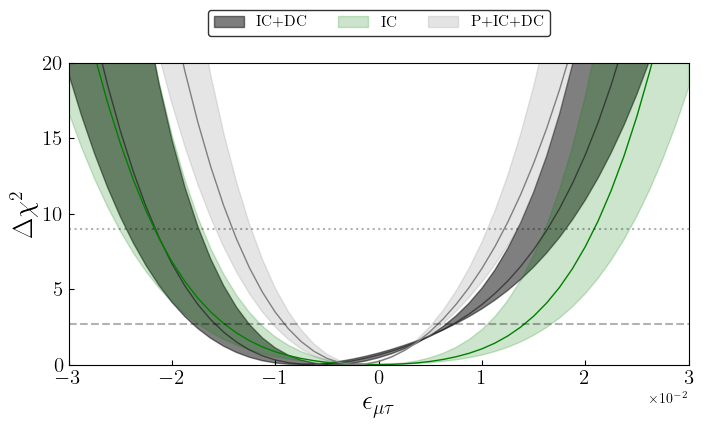

In [37]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
alpha_regions = 0.2
alpha_lines = 1
lw=1

nsi_param = 'emt'
ax.fill_between(fine_e_ranges[1], best_cases[f'ID_{nsi_param}'], worst_cases[f'ID_{nsi_param}'],label='IC+DC', alpha=alpha_regions+0.3, color='k')
ax.plot(fine_e_ranges[1], normal_cases[f'ID_{nsi_param}'], alpha=alpha_lines-0.5, lw=lw,color='k')

ax.fill_between(fine_e_ranges[1], best_cases[f'I_{nsi_param}'], worst_cases[f'I_{nsi_param}'],label='IC', alpha=alpha_regions, color='g')
ax.plot(fine_e_ranges[1], normal_cases[f'I_{nsi_param}'], alpha=alpha_lines, lw=lw, color='g')

ax.fill_between(fine_e_ranges[1], best_cases[f'PID_{nsi_param}'], worst_cases[f'PID_{nsi_param}'], label='P+IC+DC', alpha=alpha_regions,color='grey')
ax.plot(fine_e_ranges[1], normal_cases[f'PID_{nsi_param}'], alpha=alpha_lines, lw=lw,color='grey')



ax.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')
ax.axhline(chi2.ppf(0.9973,1), alpha=0.3, c='black', ls = ':')

ax.set_ylim(bottom=0, top=20)
ax.set_xlim(left=-3e-2, right=3e-2)
ax.set_xlabel(r'$\epsilon_{\mu\tau}$', fontsize=20)
ax.set_ylabel(r'$\Delta \chi^2$', fontsize=20)
ax.tick_params(labelsize=15)
handles, labels = ax.get_legend_handles_labels()
leg= ax.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.2),fontsize=11)
leg.get_frame().set_edgecolor('k')
ax.tick_params(axis='both', direction='in', which='both')
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.subplots_adjust(hspace=0.6)
fig.savefig('article/figures/PID_3D_emt.pdf', bbox_inches="tight")

<ipython-input-36-d7434e1bdf27>:34: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.5)


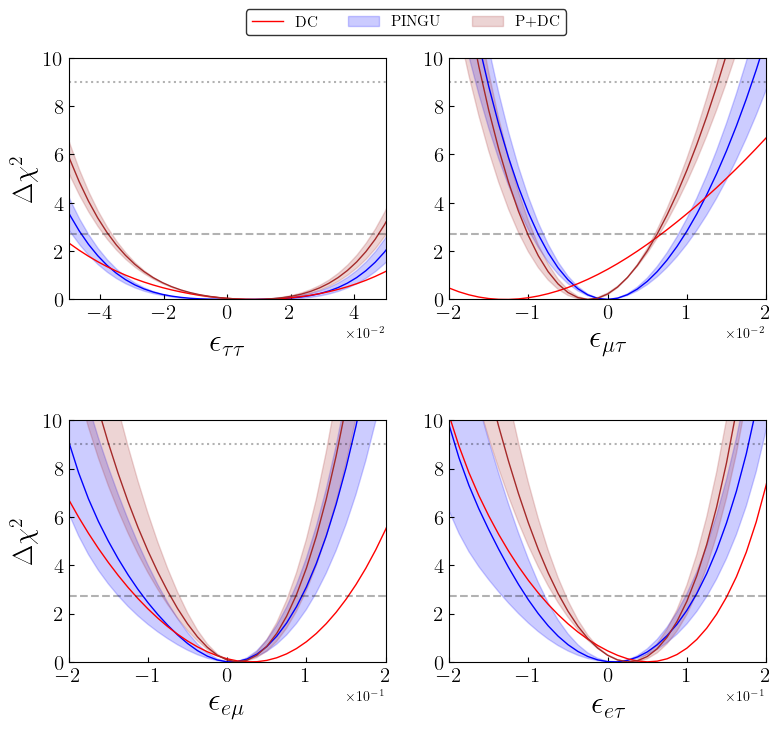

In [36]:
fig, ax = plt.subplots(2,2,figsize=(9,8), constrained_layout=True)
ax = ax.flatten()
demidov_ett = (-0.055, 0.056)
demidov_emt = (-0.023, 0.016)
demidov_eem = (-0.21, 0.20)
demidov_eet = (-0.19, 0.20)
xlabels = [r'$\epsilon_{\tau\tau}$', r'$\epsilon_{\mu\tau}$', r'$\epsilon_{e\mu}$', r'$\epsilon_{e\tau}$']
demidovs =[demidov_ett, demidov_emt, demidov_eem, demidov_eet]
alpha_regions = 0.2
alpha_lines = 1
lw=1
xy_limits = [(5e-2,10), (2e-2,10), (2e-1,10), (2e-1,10)]
for i in range(4):

    ax[i].fill_between(fine_e_ranges[i], worst_cases[f'P_{nsi_list[i]}'], best_cases[f'P_{nsi_list[i]}'], label='PINGU', alpha=alpha_regions, color='b')
    ax[i].plot(fine_e_ranges[i], normal_cases[f'P_{nsi_list[i]}'], alpha=alpha_lines, color='b', lw=lw)
    ax[i].plot(fine_e_ranges[i], normal_cases[f'D_{nsi_list[i]}'], label='DC', alpha=alpha_lines, color='r', lw=lw)
    ax[i].fill_between(fine_e_ranges[i], worst_cases[f'PD_{nsi_list[i]}'], best_cases[f'PD_{nsi_list[i]}'], label='P+DC', alpha=alpha_regions, color='brown')
    ax[i].plot(fine_e_ranges[i], normal_cases[f'PD_{nsi_list[i]}'], alpha=1, color='brown',lw=lw)

    ax[i].axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')
    ax[i].axhline(chi2.ppf(0.9973,1), alpha=0.3, c='black', ls = ':')
    ax[i].set_ylim(bottom=0,top=xy_limits[i][1])
    ax[i].set_xlim((-xy_limits[i][0],xy_limits[i][0]))
    ax[i].set_xlabel(xlabels[i], fontsize=23)
    ax[i].tick_params(labelsize=15,axis='both', direction='in', which='both')
    ax[i].ticklabel_format(axis="x", style="sci", scilimits=(0,0))

ax[0].set_ylabel(r'$\Delta \chi^2$', fontsize=20)
ax[2].set_ylabel(r'$\Delta \chi^2$', fontsize=20)
handles, labels = ax[1].get_legend_handles_labels()
leg= fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.95),fontsize=11)
leg.get_frame().set_edgecolor('k')
plt.subplots_adjust(hspace=0.5)
plt.savefig('./article/figures/joint_3D_NO.pdf', bbox_inches="tight")
#save(fig, 'joint_3D_NO') #Doesnt work, legend removed
#savethesis(fig, 'joint_3D_NO')#Doesnt work, legend removed

In [32]:
index_list = ['$\ett$', '$\emt$', '$\eem$', '$\eet$']
colnames = ['Best 90', 'Best 3s', 'Normal 90', 'Normal 3s', 'Worst 90', 'Worst 3s']
df_I = pd.DataFrame(columns=colnames,index=index_list, dtype=object)
df_D = pd.DataFrame(columns=colnames,index=index_list, dtype=object)
df_ID = pd.DataFrame(columns=colnames,index=index_list, dtype=object)

df_P = pd.DataFrame(columns=colnames,index=index_list, dtype=object)
df_PD = pd.DataFrame(columns=colnames,index=index_list, dtype=object)
df_PID = pd.DataFrame(columns=colnames,index=index_list, dtype=object)

cl90 = chi2.ppf(0.9,1)
cl3s = chi2.ppf(0.9973,1)
factors = [1e0,1e0,1e0,1e0]
for i,epsilon in enumerate(nsi_list):
    for j, df in enumerate([df_D, df_P, df_PD]):
        df.loc[index_list[i],f'Best 90'] = np.round(factors[i]*sproot(splrep(fine_e_ranges[i], best_cases[f'{experiment_list[j]}_{epsilon}'] - cl90)),3)
        df.loc[index_list[i],f'Best 3s'] = np.round(factors[i]*sproot(splrep(fine_e_ranges[i], best_cases[f'{experiment_list[j]}_{epsilon}'] - cl3s)),3)

        df.loc[index_list[i],f'Normal 90'] = np.round(factors[i]*sproot(splrep(fine_e_ranges[i], normal_cases[f'{experiment_list[j]}_{epsilon}'] - cl90)),3)
        df.loc[index_list[i],f'Normal 3s'] = np.round(factors[i]*sproot(splrep(fine_e_ranges[i], normal_cases[f'{experiment_list[j]}_{epsilon}'] - cl3s)),3)

        df.loc[index_list[i],f'Worst 90'] = np.round(factors[i]*sproot(splrep(fine_e_ranges[i], worst_cases[f'{experiment_list[j]}_{epsilon}'] - cl90)),3)
        df.loc[index_list[i],f'Worst 3s'] = np.round(factors[i]*sproot(splrep(fine_e_ranges[i], worst_cases[f'{experiment_list[j]}_{epsilon}'] - cl3s)),3)

for i, df in enumerate([df_I, df_ID, df_PID]): 
    df.loc[index_list[1],f'Best 90'] = np.round(factors[i]*sproot(splrep(fine_e_ranges[1], best_cases[f'{experiment_list_full[i]}_emt'] - cl90)),3)
    df.loc[index_list[1],f'Best 3s'] = np.round(factors[i]*sproot(splrep(fine_e_ranges[1], best_cases[f'{experiment_list_full[i]}_emt'] - cl3s)),3)

    df.loc[index_list[1],f'Normal 90'] = np.round(factors[i]*sproot(splrep(fine_e_ranges[1], normal_cases[f'{experiment_list_full[i]}_emt'] - cl90)),3)
    df.loc[index_list[1],f'Normal 3s'] = np.round(factors[i]*sproot(splrep(fine_e_ranges[1], normal_cases[f'{experiment_list_full[i]}_emt'] - cl3s)),3)

    df.loc[index_list[1],f'Worst 90'] = np.round(factors[i]*sproot(splrep(fine_e_ranges[1], worst_cases[f'{experiment_list_full[i]}_emt'] - cl90)),3)
    df.loc[index_list[1],f'Worst 3s'] = np.round(factors[i]*sproot(splrep(fine_e_ranges[1], worst_cases[f'{experiment_list_full[i]}_emt'] - cl3s)),3)

In [33]:
ID_table = pd.concat([df_I, df_D,df_ID]).dropna()

PID_table = pd.concat([df_P, df_PD,df_PID]).dropna()

In [34]:
print(ID_table.to_latex(header=['Best 90\% CL','Best $3\sigma$','Normal 90\% CL','Normal $3\sigma$','Worst 90\% CL','Worst $3\sigma$'], index_names=True, column_format='lcccc',escape=False))

\begin{tabular}{lcccc}
\toprule
{} &     Best 90\% CL &   Best $3\sigma$ &   Normal 90\% CL & Normal $3\sigma$ &    Worst 90\% CL &  Worst $3\sigma$ \\
\midrule
$\emt$ &  [-0.008, 0.009] &  [-0.014, 0.017] &   [-0.009, 0.01] &  [-0.015, 0.018] &   [-0.01, 0.011] &   [-0.017, 0.02] \\
$\ett$ &  [-0.044, 0.051] &  [-0.062, 0.069] &  [-0.046, 0.054] &         [-0.065] &  [-0.049, 0.057] &          [-0.07] \\
$\emt$ &  [-0.008, 0.009] &  [-0.014, 0.017] &   [-0.009, 0.01] &  [-0.015, 0.018] &   [-0.01, 0.011] &   [-0.017, 0.02] \\
$\eem$ &  [-0.079, 0.081] &   [-0.16, 0.138] &  [-0.106, 0.094] &  [-0.199, 0.157] &   [-0.137, 0.11] &   [-0.228, 0.18] \\
$\eet$ &  [-0.079, 0.098] &  [-0.148, 0.161] &   [-0.103, 0.11] &  [-0.193, 0.178] &  [-0.132, 0.125] &  [-0.226, 0.196] \\
$\emt$ &  [-0.029, 0.007] &          [0.026] &  [-0.029, 0.007] &          [0.026] &  [-0.029, 0.007] &          [0.026] \\
\bottomrule
\end{tabular}



In [35]:
print(PID_table.to_latex(header=['Best 90\% CL','Best $3\sigma$','Normal 90\% CL','Normal $3\sigma$','Worst 90\% CL','Worst $3\sigma$'], index_names=True, column_format='lcccc',escape=False))

\begin{tabular}{lcccc}
\toprule
{} &     Best 90\% CL &   Best $3\sigma$ &   Normal 90\% CL & Normal $3\sigma$ &    Worst 90\% CL &  Worst $3\sigma$ \\
\midrule
$\ett$ &  [-0.054, 0.067] &               [] &  [-0.054, 0.067] &               [] &  [-0.054, 0.067] &               [] \\
$\emt$ &  [-0.029, 0.007] &          [0.026] &  [-0.029, 0.007] &          [0.026] &  [-0.029, 0.007] &          [0.026] \\
$\eem$ &  [-0.115, 0.152] &  [-0.234, 0.242] &  [-0.115, 0.152] &  [-0.234, 0.242] &  [-0.115, 0.152] &  [-0.234, 0.242] \\
$\eet$ &   [-0.084, 0.15] &  [-0.188, 0.212] &   [-0.084, 0.15] &  [-0.188, 0.212] &   [-0.084, 0.15] &  [-0.188, 0.212] \\
$\ett$ &  [-0.036, 0.046] &  [-0.056, 0.064] &  [-0.038, 0.048] &  [-0.058, 0.067] &   [-0.039, 0.05] &          [-0.06] \\
$\emt$ &  [-0.009, 0.006] &  [-0.015, 0.013] &   [-0.01, 0.006] &  [-0.016, 0.014] &  [-0.011, 0.007] &  [-0.017, 0.015] \\
$\eem$ &   [-0.06, 0.077] &  [-0.126, 0.127] &  [-0.071, 0.086] &  [-0.149, 0.141] &  [-0.082, 